In [3]:
from utils_vae import read_field
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow
# import keras 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import sys, importlib

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense,Flatten 
from VAES import encoder_gen , dense_gen,encoder_dense,cloud_model,kl,schedule,decoder_dense
import matplotlib.pyplot as plt


In [2]:
print(tensorflow.__version__)
# importlib.reload(sys.modules['VAES'])
from VAES import encoder_gen , dense_gen,encoder_dense,cloud_model,kl,schedule,decoder_dense

2.9.1


In [3]:
path = "/glade/scratch/sshamekh/dyamond/SAM_highres/"


SAM data: degree in longitude is constant as the radius changes. This means moving poleward, the models resolution increases. The latitudinal resolution has been reduced moving poleward in order for the models grid to stay close to square shape. Models resolution near the equator is about 4.3 and it reduces to 4.1 at 20 S/N. 

Now, to coarse grain the data, we approxmate models resolution to be 4.2 km in both lon lat direction. 
Then we decide the rescalaing size. This is our large scale, or GCM size grid. Here I represent it with largescale. 

In [2]:
# %%time
import sys, importlib
importlib.reload(sys.modules['utils_vae'])
from utils_vae import train_test_data
t1 = 0
t2 = 10
high_res = 4.0 # km 
large_scale = 128#km
dim = int(large_scale/high_res)

x_train_hr , x_train_lg , y_train_lg , x_test_hr, x_test_lg , y_test_lg = train_test_data(path, high_res,large_scale,t1,t2,threshold_precip = 0.01)


In [42]:
from VAES import encoder_gen , dense_gen,encoder_dense,cloud_model,kl,schedule,decoder_dense

# # Opening JSON file
with open('config_32_RI_decoder_4nodes.json') as json_file:
    model_config = json.load(json_file)
importlib.reload(sys.modules['VAES'])


In [28]:
class Loss_log_like( keras.layers.Layer ):
    def __init__(self,name = None):
        super(Loss_log_like,self).__init__(name= name)
        self.loss_mse = tf.keras.losses.MeanSquaredError()
    
    def call(self,inputs , weights = 1):
        n_dims = 1
        ytrue,ypred = inputs['true'],inputs['pred']
        mu = ypred[:, 0:n_dims]
        logsigma = ypred[:, n_dims:]

        mse = -0.5*K.sum(K.square((ytrue-mu)/K.exp(logsigma)),axis=1)
        sigma_trace = -K.sum(logsigma, axis=1)
        log2pi = -0.5*n_dims*np.log(2*np.pi)

        log_likelihood = mse+sigma_trace+log2pi

    
        loss = K.mean(-log_likelihood)
        self.add_loss(weights*loss)
        
        self.add_metric(loss,name = self.name)
        self.add_metric(self.loss_mse(mu,ytrue),name = 'mse_'+self.name)## only for comparison
        
        
        
        
#         qs = [0.975, 0.995]
#         q = tf.constant(np.array([qs]), dtype=tf.float32)
#         error = ytrue - mu
#         val = tf.maximum(q*error, (q-1)*error)
#         lossq = K.mean(val)
        
#         self.add_loss(2*lossq)
#         self.add_metric(lossq,name = self.name+'quntile')

        return ypred
    

    
class Loss_Simple( keras.layers.Layer ):
    def __init__(self,name = None):
        super(Loss_Simple,self).__init__(name= name)
        self.loss_mse = tf.keras.losses.MeanSquaredError()
    
    def call(self,inputs , weights = 1):
        n_dims = 1
        ytrue,ypred = inputs['true'],inputs['pred']
        # yp = ypred[:,0]
        loss = self.loss_mse(ytrue,ypred)
        self.add_loss(weights*loss)
        self.add_metric(self.loss_mse(ytrue,ypred),name = self.name+'mse')
        

        
        return ypred
    

class Loss_rotation_invariant( keras.layers.Layer ):
    
    def __init__(self,name = None):
        super(Loss_rotation_invariant,self).__init__(name= name)
        self.loss_mse = tf.keras.losses.MeanAbsoluteError()
        self.lambda_weight = 1
 
    def call (self,inputs, weights = 1):
        # loss: reconstruction
        y_true,y_pred = inputs['true'],inputs['pred']
        
        
        loss = self.loss_mse(y_true,y_pred)
        mean_org = K.mean(K.abs(y_true))
        self.add_loss(weights * loss/mean_org)
        self.add_metric(loss/mean_org,name = self.name)
        self.add_metric(mean_org,name = 'mean_org')
        return loss
        



In [29]:
outputs = []
coef = model_config["coef"]
dim = model_config["dim"]
inshape = model_config["inshape"]
rotation_invariant = model_config['rotation_invariant']
train_decoder = model_config['train_decoder']
inshape_cloud = (inshape+model_config["configs_encoder"]['latent_dim'],)
inshape_precip = (inshape+model_config["configs_encoder"]['latent_dim'],)


## rotating data in batch while training 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])

encoder_result = encoder_gen((dim, dim,1),model_config["configs_encoder"])
decode_zz = decoder_dense((dim, dim),model_config["config_decoder"])

clouds_cc = cloud_model(inshape_cloud,model_config["config_cloudnn"])
precip_model = dense_gen(inshape_precip,model_config["config_dense"])

inputhighres = tf.keras.layers.Input(shape=(dim, dim,1))
inputdense = tf.keras.layers.Input(shape=(inshape,))
precip_true = tf.keras.layers.Input(shape=(1,))





z_orig = encoder_result.vae_encoder(inputhighres)



z_clt = tf.keras.layers.Concatenate(axis = -1)([z_orig,inputdense])

precip = precip_model.dense_nn(z_clt)


prec_pred  = Loss_Simple(name = 'precip_loss')({'true':precip_true,'pred':precip}, weights = 1)
outputs.append(prec_pred)
if train_decoder :
    hr_reconst= decode_zz(z_orig)
    hr_pred = Loss_Simple(name= 'hr_loss')({'true':inputhighres,'pred':hr_reconst
                                            }, weights = 1)
    outputs.append(hr_pred)


if rotation_invariant:
    print ('True')
    input_rotated = data_augmentation(inputhighres)
    z_rotated = encoder_result.vae_encoder(input_rotated)
    loss_RI = Loss_rotation_invariant(name = 'rotationloss')({'true':z_orig,'pred':z_rotated})
    outputs.append(z_rotated)
    


vae = tf.keras.Model(inputs=[inputhighres,inputdense,precip_true],
                     outputs=outputs)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0004)
callback_lr=LearningRateScheduler(schedule,verbose=1)
earlyStopping=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

vae.compile(optimizer = optimizer)



shape of input after padding (None, 32, 32, 1)
shape after first convolutional layer (None, 17, 16, 16)
shape after second convolutional layer (None, 9, 8, 16)
shape before flattening (None, 5, 4, 8)
shape after flattening (None, 4)
shape at beginning of decoder (None, 1024)
shape after conv recon layer (None, 32, 32)
output shape is:  (None, 16)
output shape is:  (None, 1)
True


In [21]:
# vae.summary()

In [1]:
%%time
hist = vae.fit(
        x=[x_train_hr,x_train_lg[:,:],y_train_lg],
        epochs=100,
        batch_size=128,
        validation_split = 0.2,
        callbacks= [earlyStopping,callback_lr],
        shuffle = True
    )

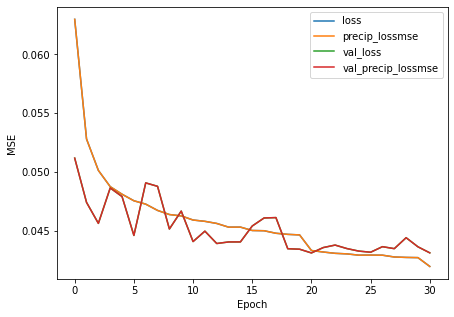

In [85]:
fig = plt.figure(figsize=[7,5])
for ky in hist.history.keys():
    if ky!='lr':
        plt.plot(hist.history[ky][:],label = ky)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
           
plt.show()

# fig.savefig('mse.jpeg',bbox_inches = 'tight',dpi = 100)

In [24]:
from sklearn.metrics import r2_score

predict 

r2_score(y_test[:,0],predict[0])

0.8993898252175628